# Centralised EMNIST solution (benchmark)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import json
import numpy as np
%matplotlib inline 
from matplotlib import pyplot as plt

## Model Hyperparameters

In [2]:
epochs = 5
batch_size_train = 128
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.9

# Other configuration
random_seed = 1
torch.manual_seed(random_seed) # For model reproducibility
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

## Load and preprocess data

In [3]:
# Where to save MNIST train and test data
data_path = '../leaf/data/femnist/data/raw_data/'

In [4]:
# Convert images to tensors and normalise (implicitly) in range [0, 1]
transform = transforms.Compose([transforms.ToTensor()])

# Using updated link for dataset: https://cloudstor.aarnet.edu.au/plus/s/ZNmuFiuQTqZlu9W/download

trainset = torchvision.datasets.EMNIST(root=data_path, split='byclass', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.EMNIST(root=data_path, split='byclass', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test,
                                         shuffle=False, num_workers=2)

classes = [str(i) for i in range(10)]
classes += list(map(chr, range(65, 91)))
classes += list(map(chr, range(97, 123)))

### Take a look at images

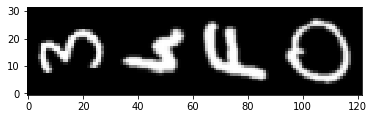

    3     h     F     0


In [5]:
def imshow(img):
    img = img
    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), origin='lower')
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Define the network

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 62)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop_out = nn.Dropout()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.drop_out(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.drop_out(x)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.drop_out(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

### Define Loss and Optimizer

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

## Train the model

In [ ]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.709
[1,  4000] loss: 0.989


## Save model

In [ ]:
model_path = 'emnist_centralised.pth'
torch.save(net.state_dict(), model_path)

## Test network on unseen data

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
# Reload saved model
net = Net().to(device)
net.load_state_dict(torch.load(model_path))


outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

## Analyse Performance

### Overall

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

### Per class

In [ ]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(predicted)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))